In [1]:
import pennylane as qml
import pennylane.numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from pennylane.operation import Operation, AnyWires

### Data preprocessing

In [2]:
iris = datasets.load_iris()

In [3]:
n_features=iris.data.shape[1]
#XXX: exclude class 2
xy_labels=[(iris.data[idx,:],iris.target[idx]) for idx in range(len(iris.data)) if iris.target[idx]!=2]
feature_list=[[x_lab[ft_i] for x_lab,y_lab in xy_labels] for ft_i in range(n_features)]

#standardize features
mean_std_list=[[np.mean(feature_list[ft_i]),np.std(feature_list[ft_i])] for ft_i in range(n_features)]
xy_labels_stdd=[([(el[0][ft_i]-mean_std_list[ft_i][0])/mean_std_list[ft_i][1] for ft_i in range(n_features)],el[1]) for ei,el in enumerate(xy_labels)]
#norms_list=[np.sqrt(np.sum([val**2 for val in el[0]])) for el in xy_labels_stdd]
#xy_labels_stdd=[([val/norms_list[ei] for val in el[0]],el[1]) for ei,el in enumerate(xy_labels_stdd)]
xy_labels=xy_labels_stdd
#xy_labels

X=np.array([x for x,y in xy_labels_stdd])
y_=np.array([y for x,y in xy_labels_stdd])
#y = torch.unsqueeze(torch.tensor(y,requires_grad=False), 1)
#y_hot = torch.scatter(torch.zeros((200, 2),requires_grad=False), 1, y_, 1)
X = torch.tensor(X, requires_grad=False).float()
y = torch.tensor(y_, requires_grad=False).long()

In [7]:
import pennylane.numpy as np

#def init_method(w):
#    print(w)
#    torch.nn.init.uniform_(w, a=0.0, b=0.02*np.pi)
#    print(w)
s=0.02
init_method=lambda x: torch.nn.init.uniform_(x,a=0.,b=s*np.pi)

n_qubits1=3
n_layers1 = 3
n_pars1 = 2*n_qubits1*n_layers1
dev1 = qml.device("default.mixed", wires=n_qubits1)
@qml.qnode(dev1)
def probs_single1(inputs, weights):
    shape=[2,3,3]
    nq=np.max([shape[0],shape[2]])
#    # load input
#    print("inputs:",inputs)
#    print("weights:",weights)
    #TODO: make general loadings
    for idx in range(0,n_features):
        gate=qml.RX if idx<shape[0] else qml.RZ
        gate(np.arctan(inputs[...,idx]),idx%2,id=f"$\\alpha1_{{{{{idx}}}}}$")
        
    # parameterized circuit 
    for lay_idx in range(shape[1]):
        ctr=0
        for eo in range(2):
            for qi in range(eo,nq-eo,2):
                if qi<nq-1:
                    qml.CZ(wires=[qi,qi+1])
        for gate in [qml.RX,qml.RZ]:
            for qi in range(nq):
                gate(weights[lay_idx][ctr],wires=qi,id=f"$\\theta1_{{{{{ctr}}}}}$")
                ctr+=1
        
    probs=qml.probs(wires=range(0,shape[2]))
    return probs
weight_shapes1 = {"weights": (n_layers1, n_pars1)}
qlayer1 = qml.qnn.TorchLayer(probs_single1, weight_shapes1,init_method=init_method)


n_qubits2=3
n_layers2 = 2
n_pars2 = 2*n_qubits2*n_layers2
dev2 = qml.device("default.mixed", wires=n_qubits2)
@qml.qnode(dev2)
def probs_single2(inputs, weights):
    shape=[3,2,1]
    nq=np.max([shape[0],shape[2]])
#    # load input
#    print("inputs:",inputs)
#    print("weights:",weights)
    #TODO: make general loadings
    for idx in range(0,6):
        gate=qml.RY if idx<3 else qml.RZ
        gate(torch.arctan(np.pi*(inputs[...,idx]-0.5)),idx%3,id=f"$\\alpha2_{{{{{idx}}}}}$")
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    for idx in range(6,8):
        #gate=[qml.RX,qml.RZ][idx-6]
        qml.RY(torch.arctan(np.pi*(inputs[...,idx]-0.5)),idx-6,id=f"$\\alpha2_{{{{{idx}}}}}$")
        
    # parameterized circuit 
    for lay_idx in range(shape[1]):
        ctr=0
        for eo in range(2):
            for qi in range(eo,nq-eo,2):
                if qi<nq-1:
                    qml.CZ(wires=[qi,qi+1])
        for gate in [qml.RY,qml.RZ]:
            for qi in range(nq):
                gate(weights[lay_idx][ctr],wires=qi,id=f"$\\theta2_{{{{{ctr}}}}}$")
                ctr+=1
        
    probs=qml.probs(wires=range(0,shape[2]))
    return probs
weight_shapes2 = {"weights": (n_layers2, n_pars2)}
qlayer2 = qml.qnn.TorchLayer(probs_single2, weight_shapes2,init_method=init_method)

/home/joe/.local/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 1224x288 with 1 Axes>, <Axes:>)

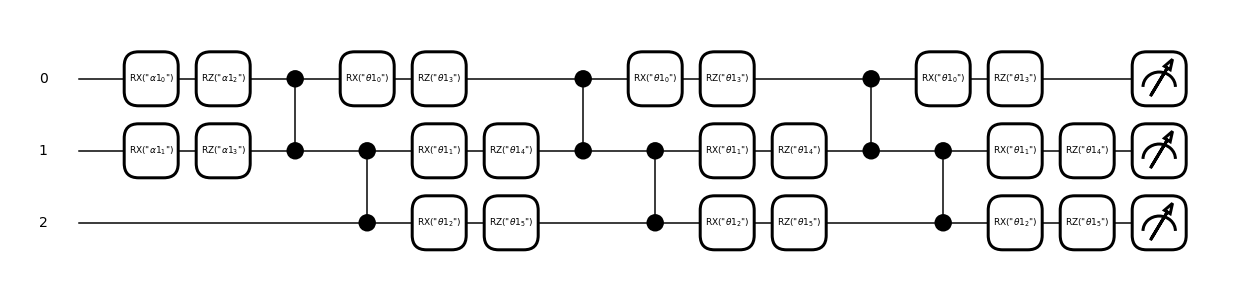

In [345]:
qml.draw_mpl(probs_single1)(torch.rand(4),np.random.random(weight_shapes1['weights']))

/home/joe/.local/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 1152x288 with 1 Axes>, <Axes:>)

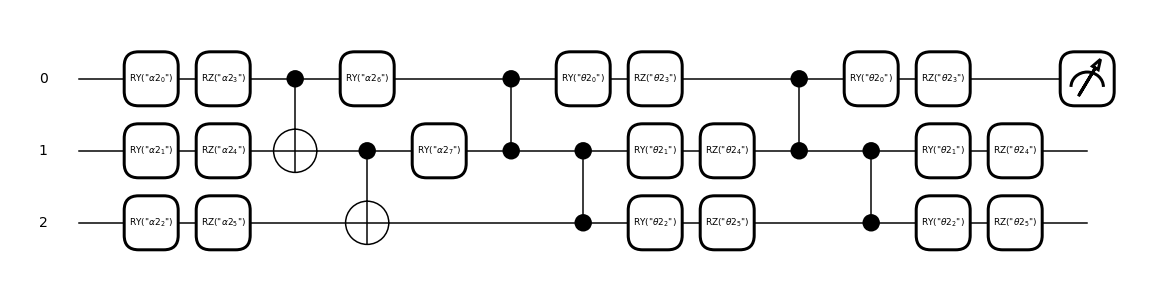

In [8]:
qml.draw_mpl(probs_single2)(torch.rand(8),np.random.random(weight_shapes2['weights']))

In [1]:
qml.draw_mpl(probs_single2)(torch.rand(8),np.random.random(weight_shapes2['weights']))

NameError: name 'qml' is not defined

In [347]:
import pennylane.numpy as np
layers = [qlayer1,qlayer2]
model = torch.nn.Sequential(*layers)
#model.apply(init_method)

#opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt = torch.optim.Adam(model.parameters(),lr=0.1)
#opt = torch.optim.Adam(model.parameters(),lr=0.05)
#loss = torch.nn.MSELoss()
loss = torch.nn.CrossEntropyLoss()
for pr in model.parameters():
    print(pr)

Parameter containing:
tensor([[0.0057, 0.0179, 0.0593, 0.0621, 0.0418, 0.0298, 0.0417, 0.0598, 0.0469,
         0.0137, 0.0036, 0.0268, 0.0261, 0.0168, 0.0393, 0.0624, 0.0585, 0.0088],
        [0.0002, 0.0310, 0.0175, 0.0317, 0.0439, 0.0468, 0.0175, 0.0357, 0.0095,
         0.0416, 0.0498, 0.0318, 0.0580, 0.0204, 0.0081, 0.0306, 0.0487, 0.0334],
        [0.0153, 0.0539, 0.0187, 0.0405, 0.0601, 0.0566, 0.0233, 0.0002, 0.0100,
         0.0239, 0.0081, 0.0610, 0.0332, 0.0065, 0.0100, 0.0098, 0.0120, 0.0499]],
       requires_grad=True)
Parameter containing:
tensor([[0.0429, 0.0426, 0.0490, 0.0503, 0.0495, 0.0375, 0.0155, 0.0400, 0.0327,
         0.0549, 0.0576, 0.0618],
        [0.0412, 0.0451, 0.0432, 0.0058, 0.0047, 0.0483, 0.0496, 0.0517, 0.0504,
         0.0499, 0.0415, 0.0048]], requires_grad=True)


In [348]:
#torch.nn.CrossEntropyLoss?

In [349]:
#y = y_hot.float()
#y_hot = y_hot.float()

batch_size = 8
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y)), batch_size=batch_size, shuffle=True, drop_last=True
)
epochs = 20

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

#        print(xs)
        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()
#        print(xs, model(xs),ys,loss_evaluated)

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.2988
Average loss over epoch 2: 0.2677
Average loss over epoch 3: 0.2651
Average loss over epoch 4: 0.2585
Average loss over epoch 5: 0.2562
Average loss over epoch 6: 0.2552
Average loss over epoch 7: 0.2555
Average loss over epoch 8: 0.2539
Average loss over epoch 9: 0.2497
Average loss over epoch 10: 0.2433
Average loss over epoch 11: 0.2415
Average loss over epoch 12: 0.2144
Average loss over epoch 13: 0.2114
Average loss over epoch 14: 0.2114
Average loss over epoch 15: 0.2105
Average loss over epoch 16: 0.2119
Average loss over epoch 17: 0.2103
Average loss over epoch 18: 0.2094
Average loss over epoch 19: 0.2123
Average loss over epoch 20: 0.2148
Accuracy: 99.0%


In [268]:
#predictions = torch.argmax(y_pred, axis=1).detach().numpy()

In [350]:
pbs_arr=[]
for x_lab, y_lab in zip(X,y):
    pbs=model(x_lab).detach().numpy()
    pbs_arr.append(pbs[:2])
    idx_max=np.argmax(pbs[:2])
#    y_lab_pred="0" if idx_max==1 else "1"
    print(int(y_lab), " ", idx_max, " ", pbs)
pbs_arr=np.array(pbs_arr)

0   0   [0.80643725 0.19356307]
0   0   [0.54897165 0.45102853]
0   0   [0.7560035  0.24399664]
0   0   [0.7157322  0.28426787]
0   0   [0.8337667  0.16623342]
0   0   [0.787862   0.21213822]
0   0   [0.83916146 0.16083862]
0   0   [0.8082528  0.19174755]
0   0   [0.54709375 0.45290643]
0   0   [0.66194004 0.3380602 ]
0   0   [0.7352039  0.26479617]
0   0   [0.8344243  0.16557595]
0   0   [0.5834218 0.4165784]
0   0   [0.61411995 0.38588032]
0   0   [0.5370872  0.46291304]
0   0   [0.6600357 0.3399644]
0   0   [0.78467983 0.21532026]
0   0   [0.8151713  0.18482889]
0   0   [0.5661639  0.43383634]
0   0   [0.8406384  0.15936191]
0   0   [0.63892746 0.3610729 ]
0   0   [0.8433052 0.156695 ]
0   0   [0.8424481 0.1575521]
0   0   [0.78022766 0.21977246]
0   0   [0.8452144  0.15478568]
0   0   [0.53195024 0.46804997]
0   0   [0.8255308 0.1744694]
0   0   [0.78380287 0.21619743]
0   0   [0.74917203 0.25082818]
0   0   [0.77909327 0.22090691]
0   0   [0.6967863  0.30321392]
0   0   [0.670766 

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


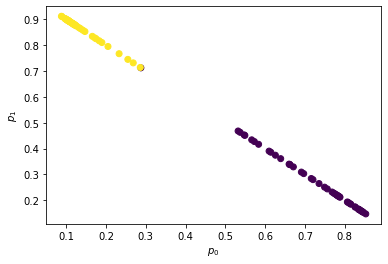

In [351]:
%pylab inline
scatter(pbs_arr[:,0],pbs_arr[:,1],c=[y_lab for x_lab,y_lab in xy_labels])
xlabel(r"$p_{0}$")
ylabel(r"$p_{1}$");

## Non-linearly-separable data

In [23]:
n_features=iris.data.shape[1]
xy_labels=[(iris.data[idx,:],iris.target[idx]) for idx in range(len(iris.data))]
feature_list=[[x_lab[ft_i] for x_lab,y_lab in xy_labels] for ft_i in range(n_features)]

#standardize features
mean_std_list=[[np.mean(feature_list[ft_i]),np.std(feature_list[ft_i])] for ft_i in range(n_features)]
xy_labels_stdd=[([(el[0][ft_i]-mean_std_list[ft_i][0])/mean_std_list[ft_i][1] for ft_i in range(n_features)],el[1]) for ei,el in enumerate(xy_labels)]
#norms_list=[np.sqrt(np.sum([val**2 for val in el[0]])) for el in xy_labels_stdd]
#xy_labels_stdd=[([val/norms_list[ei] for val in el[0]],el[1]) for ei,el in enumerate(xy_labels_stdd)]
xy_labels=xy_labels_stdd
#xy_labels

X=np.array([x for x,y in xy_labels_stdd])
y_=np.array([y for x,y in xy_labels_stdd])
#y = torch.unsqueeze(torch.tensor(y,requires_grad=False), 1)
#y_hot = torch.scatter(torch.zeros((200, 2),requires_grad=False), 1, y_, 1)
X = torch.tensor(X, requires_grad=False).float()
y = torch.tensor(y_, requires_grad=False).long()

In [36]:
import pennylane.numpy as np

#def init_method(w):
#    print(w)
#    torch.nn.init.uniform_(w, a=0.0, b=0.02*np.pi)
#    print(w)
s=0.05
init_method=lambda x: torch.nn.init.uniform_(x,a=0.,b=s*np.pi)

n_qubits1=4
n_layers1 = 3
n_pars1 = 2*n_qubits1*n_layers1
dev1 = qml.device("default.qubit", wires=n_qubits1)
@qml.qnode(dev1)
def probs_single1(inputs, weights):
    shape=[4,3,4]
    nq=np.max([shape[0],shape[2]])
#    # load input
#    print("inputs:",inputs)
#    print("weights:",weights)
    #TODO: make general loadings
    for idx in range(0,n_features):
        gate=qml.RY if idx<shape[0] else qml.RZ
        gate(np.arctan(inputs[...,idx]),idx%4,id=f"$\\alpha1_{{{{{idx}}}}}$")
        
    # parameterized circuit 
    for lay_idx in range(shape[1]):
        ctr=0
        for eo in range(2):
            for qi in range(eo,nq-eo,2):
                if qi<nq-1:
                    qml.CZ(wires=[qi,qi+1])
        for gate in [qml.RY,qml.RZ]:
            for qi in range(nq):
                gate(weights[lay_idx][ctr],wires=qi,id=f"$\\theta1_{{{{{ctr}}}}}$")
                ctr+=1
        
    probs=qml.probs(wires=range(0,shape[2]))
    return probs
weight_shapes1 = {"weights": (n_layers1, n_pars1)}
qlayer1 = qml.qnn.TorchLayer(probs_single1, weight_shapes1,init_method=init_method)


n_qubits2=4
n_layers2 = 5
#n_pars2 = 2*n_qubits2*n_layers2
n_pars2 = 2*n_qubits2*n_layers2
dev2 = qml.device("default.qubit", wires=n_qubits2)
@qml.qnode(dev2)
def probs_single2(inputs,weights,weights_input):
    shape=[4,5,2]
    nq=np.max([shape[0],shape[2]])
#    # load input
#    print("inputs:",inputs)
#    print("weights:",weights)
    #TODO: make general loadings
    for idx in range(0,shape[0]):
        qml.RY(torch.arctan((np.pi+weights_input[0][idx])*inputs[...,idx]),idx%nq,id=f"$\\alpha2_{{{{{idx}}}}}$")
#        gate=qml.RY if idx<4 else qml.RZ
#        gate(torch.arctan((np.pi+weights_input[0][idx])*inputs[...,idx]),idx%nq,id=f"$\\alpha2_{{{{{idx}}}}}$")
#    qml.CNOT(wires=[0,1])
#    qml.CNOT(wires=[1,2])
#    for idx in range(6,8):
#        #gate=[qml.RX,qml.RZ][idx-6]
#        qml.RY(torch.arctan(np.pi*(inputs[...,idx]-0.5)),idx-6,id=f"$\\alpha2_{{{{{idx}}}}}$")
        
    # parameterized circuit 
    for lay_idx in range(shape[1]):
        ctr=0
        for eo in range(2):
            for qi in range(eo,nq-eo,2):
                if qi<nq-1:
                    qml.CZ(wires=[qi,qi+1])
        for gate in [qml.RY,qml.RZ]:
            for qi in range(nq):
                gate(weights[lay_idx][ctr],wires=qi,id=f"$\\theta2_{{{{{ctr}}}}}$")
                ctr+=1
        for idx in range((lay_idx+1)*shape[0],(lay_idx+2)*shape[0]):
            if idx<2**4:
                qml.RY(torch.arctan(weights_input[1][idx]+(np.pi+weights_input[0][idx])*inputs[...,idx]),idx%nq,id=f"$\\alpha2_{{{{{idx}}}}}$")
        
    probs=qml.probs(wires=range(0,shape[2]))
    return probs
weight_shapes2 = {"weights": (n_layers2, n_pars2), "weights_input":(2,16)}
qlayer2 = qml.qnn.TorchLayer(probs_single2, weight_shapes2,init_method=init_method)

/home/joe/.local/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 1152x360 with 1 Axes>, <Axes:>)

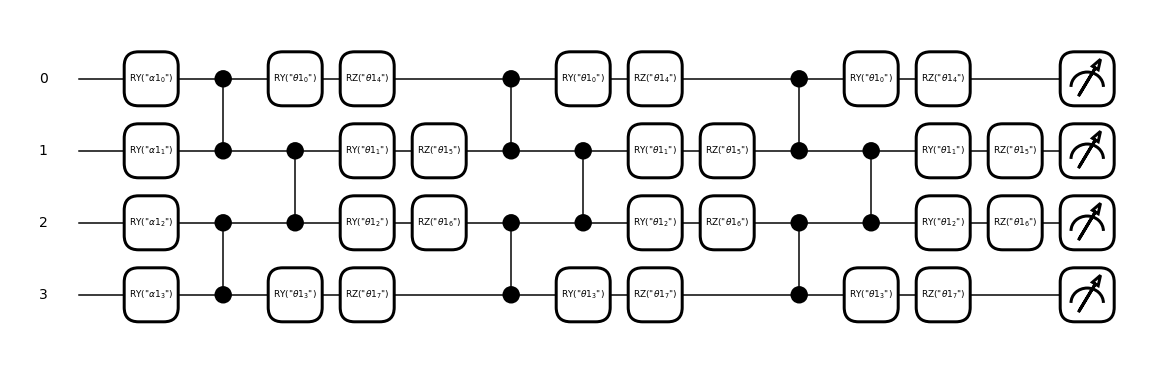

In [37]:
qml.draw_mpl(probs_single1)(torch.rand(4),np.random.random(weight_shapes1['weights']))

(<Figure size 1944x360 with 1 Axes>, <Axes:>)

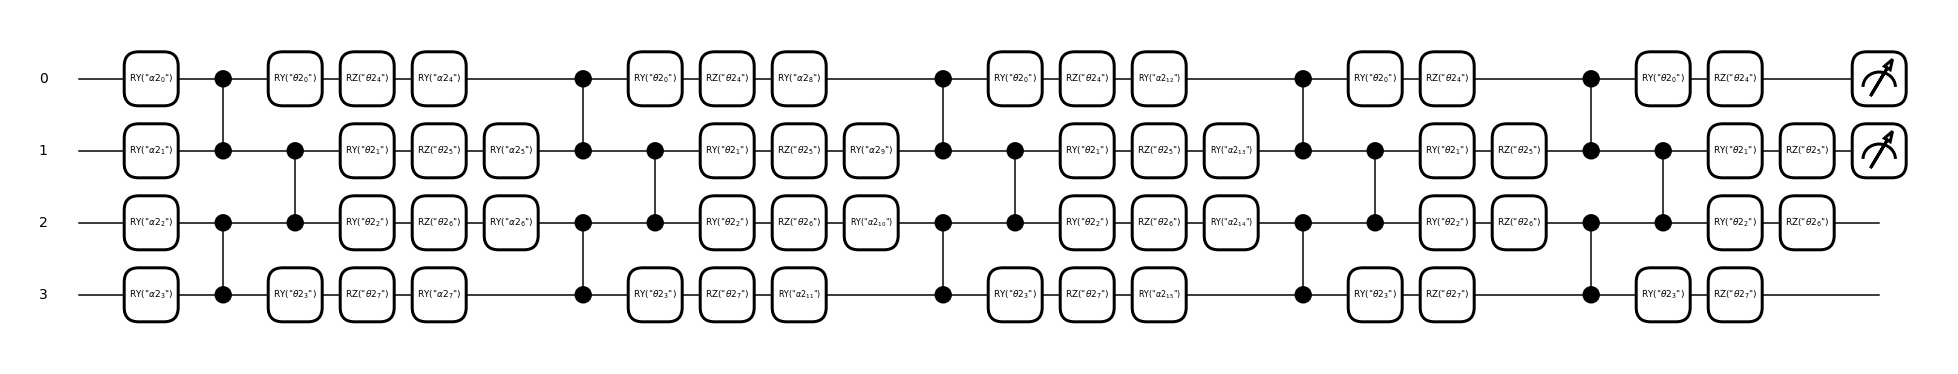

In [38]:
qml.draw_mpl(probs_single2)(torch.rand(16),torch.rand(weight_shapes2['weights']),torch.rand(weight_shapes2['weights_input']))

In [39]:
import pennylane.numpy as np
#clayer1=nn.Linear(8,8)
#softmax1=nn.Softmax(dim=1)
#sigmoid1=nn.Sigmoid()
#clayer2=nn.Linear(16,3)
#torch.nn.init.uniform_(clayer2.weight,b=0.1) 
#softmax2=nn.Softmax(dim=1)
#layers = [qlayer1,qlayer2,clayer2,softmax2]
layers = [qlayer1,qlayer2]
model = torch.nn.Sequential(*layers)
#model.apply(init_method)

#opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt = torch.optim.Adam(model.parameters(),lr=0.1)
#opt = torch.optim.Adam(model.parameters(),lr=0.05)
#loss = torch.nn.MSELoss()
loss = torch.nn.CrossEntropyLoss()
for pr in model.parameters():
    print(pr)

Parameter containing:
tensor([[0.0674, 0.0060, 0.0979, 0.0013, 0.0782, 0.0776, 0.1203, 0.0381, 0.0102,
         0.1549, 0.0476, 0.0767, 0.0938, 0.1534, 0.0772, 0.0779, 0.0759, 0.0646,
         0.0993, 0.1172, 0.0069, 0.0162, 0.0880, 0.0215],
        [0.0815, 0.0754, 0.1399, 0.1413, 0.0049, 0.0565, 0.1368, 0.1549, 0.0168,
         0.1313, 0.0803, 0.0954, 0.0421, 0.0579, 0.1232, 0.0957, 0.0663, 0.0168,
         0.1153, 0.0526, 0.1018, 0.0647, 0.1209, 0.0467],
        [0.0485, 0.1554, 0.0673, 0.0730, 0.0324, 0.1365, 0.0669, 0.0013, 0.0108,
         0.1455, 0.1187, 0.0998, 0.0382, 0.0570, 0.0926, 0.1551, 0.0376, 0.0365,
         0.0652, 0.0388, 0.0865, 0.0624, 0.1182, 0.1169]], requires_grad=True)
Parameter containing:
tensor([[0.0287, 0.0902, 0.0955, 0.1321, 0.0377, 0.1054, 0.0292, 0.0669, 0.1042,
         0.1485, 0.0480, 0.0887, 0.1370, 0.1438, 0.1065, 0.1544, 0.1505, 0.0209,
         0.1376, 0.1226, 0.0875, 0.0093, 0.0690, 0.1240, 0.0822, 0.0079, 0.0253,
         0.0119, 0.0070, 0.0559,

In [40]:
import matplotlib.pyplot as plt
def test_plot_model(y_pred):
    pbs_arr=[]
    for xii, (x_lab, y_lab) in enumerate(zip(X,y)):
        pbs=y_pred[xii].detach().numpy()
        pbs_arr.append(pbs[:3])
        idx_max=np.argmax(pbs[:3])
    #    y_lab_pred="0" if idx_max==1 else "1"
#        print(int(y_lab), " ", idx_max, " ", pbs)
    pbs_arr=np.array(pbs_arr)
    colors=['g','b','r']
    color_points=[colors[yv] for yv in y]
    fig,ax=plt.subplots()
    ax.scatter(pbs_arr[:,1],pbs_arr[:,2],c=color_points,alpha=0.5,s=5)
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


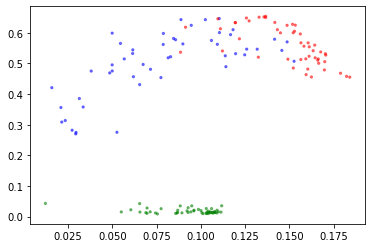

Average loss over epoch 1: 0.6743


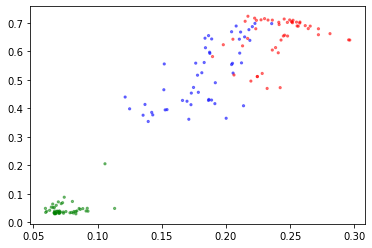

Average loss over epoch 2: 0.5883


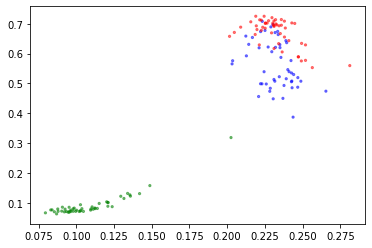

Average loss over epoch 3: 0.5658


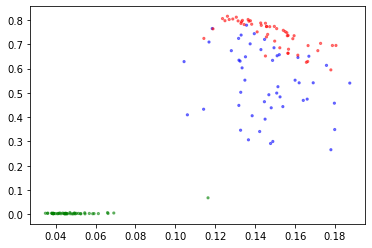

Average loss over epoch 4: 0.5484


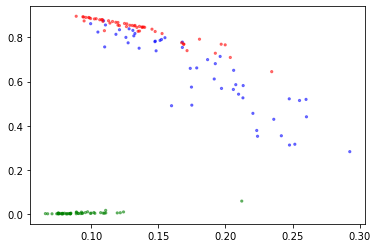

Average loss over epoch 5: 0.5366


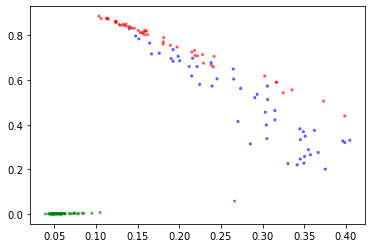

Average loss over epoch 6: 0.5255


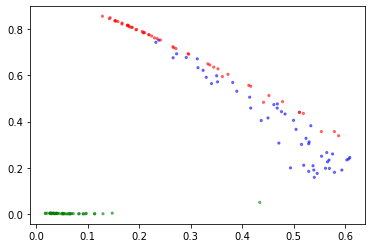

Average loss over epoch 7: 0.5101


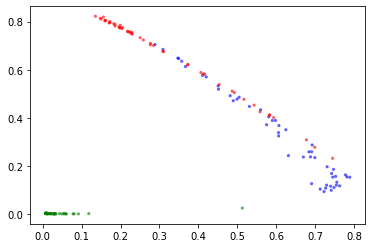

Average loss over epoch 8: 0.4903


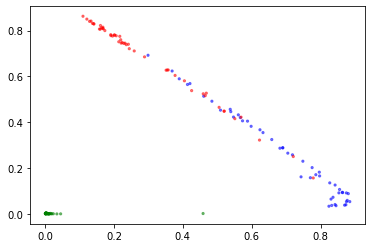

Average loss over epoch 9: 0.4736


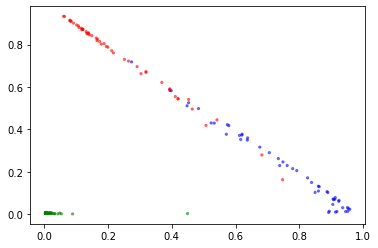

Average loss over epoch 10: 0.4551


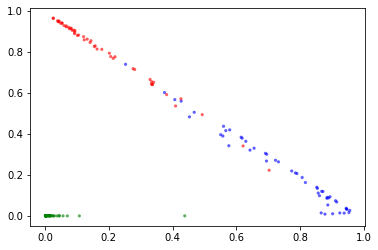

Average loss over epoch 11: 0.4432


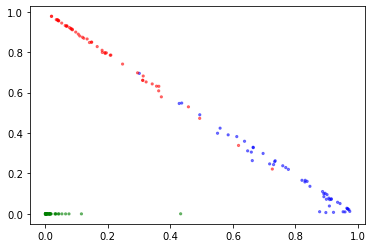

Average loss over epoch 12: 0.4349


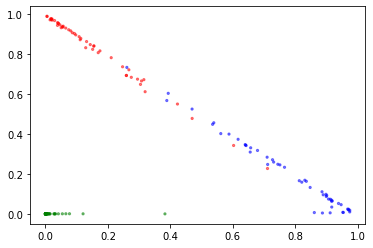

Average loss over epoch 13: 0.4297


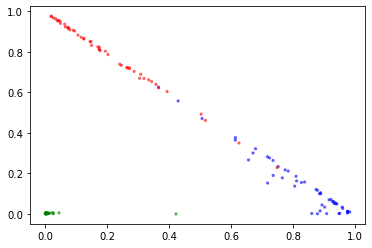

Average loss over epoch 14: 0.4294


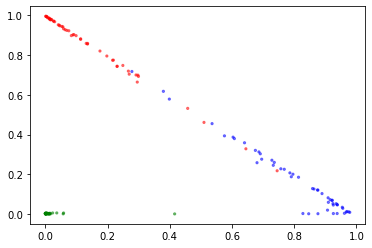

Average loss over epoch 15: 0.4243


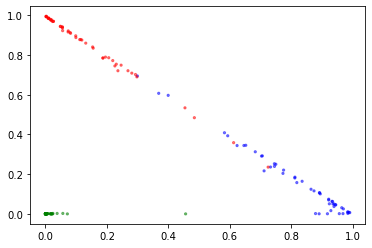

Average loss over epoch 16: 0.4214


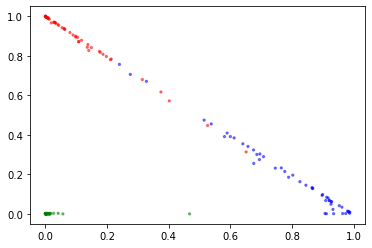

Average loss over epoch 17: 0.4214


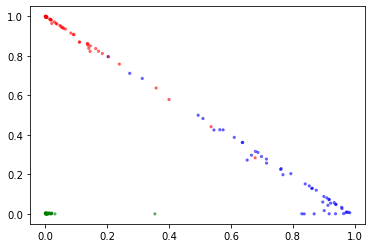

Average loss over epoch 18: 0.4232


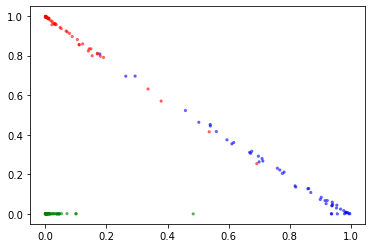

Average loss over epoch 19: 0.4215


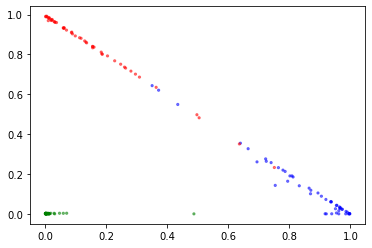

Average loss over epoch 20: 0.4179


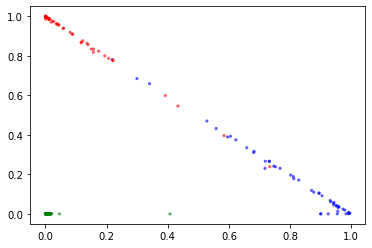

Average loss over epoch 21: 0.4166


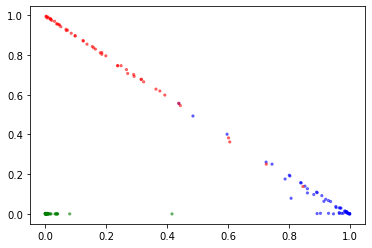

Average loss over epoch 22: 0.4153


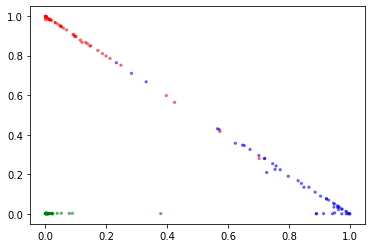

Average loss over epoch 23: 0.4170


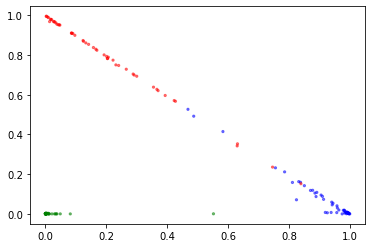

Average loss over epoch 24: 0.4137


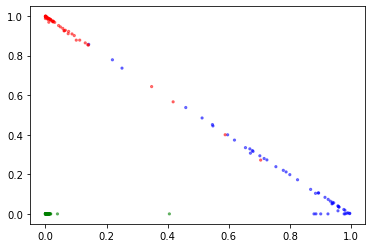

Average loss over epoch 25: 0.4111


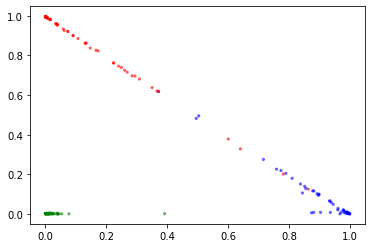

Average loss over epoch 26: 0.4126


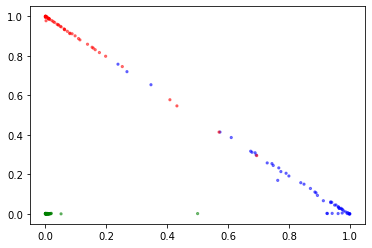

Average loss over epoch 27: 0.4090


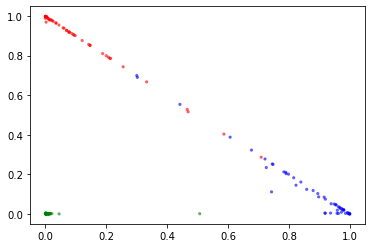

Average loss over epoch 28: 0.4090


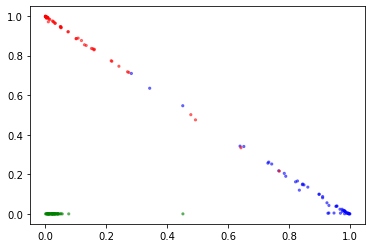

Average loss over epoch 29: 0.4077


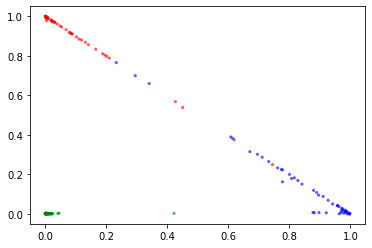

Average loss over epoch 30: 0.4079


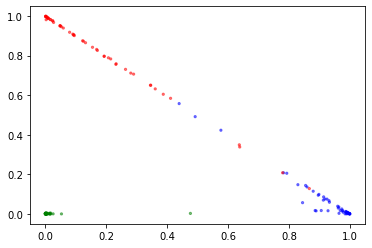

Average loss over epoch 31: 0.4072


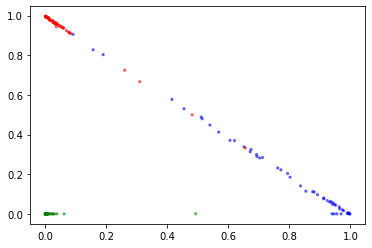

Average loss over epoch 32: 0.4119


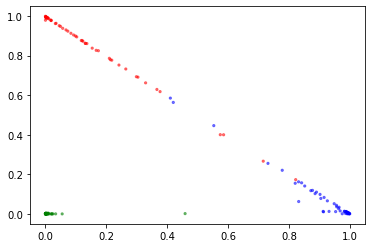

Average loss over epoch 33: 0.4092


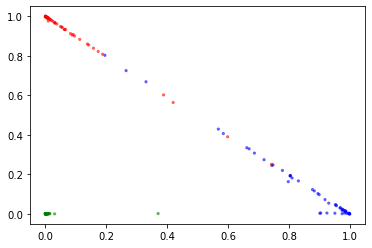

Average loss over epoch 34: 0.4063


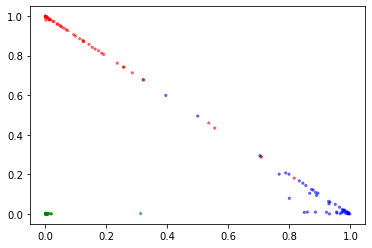

Average loss over epoch 35: 0.4057


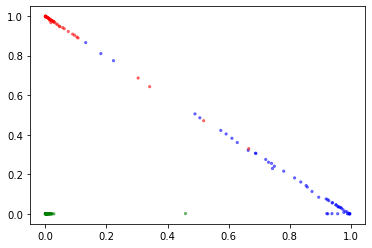

Average loss over epoch 36: 0.4114


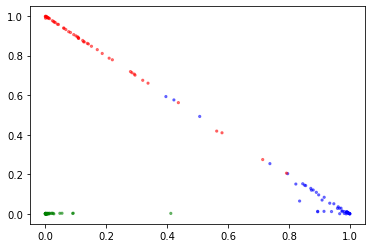

Average loss over epoch 37: 0.4124


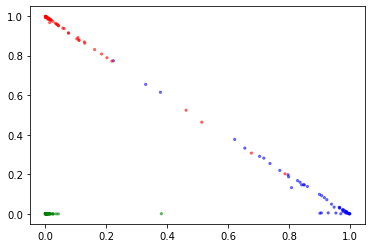

Average loss over epoch 38: 0.4062


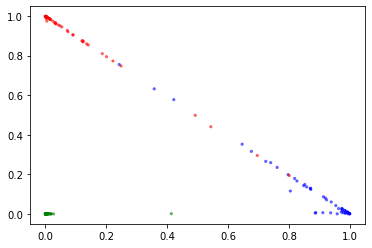

Average loss over epoch 39: 0.4069


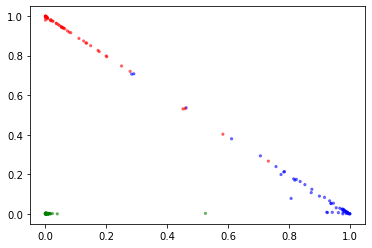

Average loss over epoch 40: 0.4048


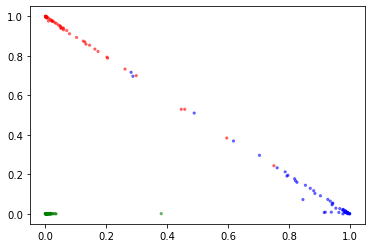

Average loss over epoch 41: 0.4054


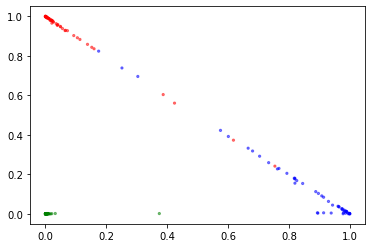

Average loss over epoch 42: 0.4058


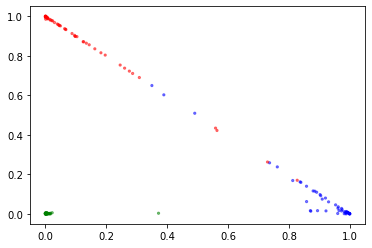

Average loss over epoch 43: 0.4071


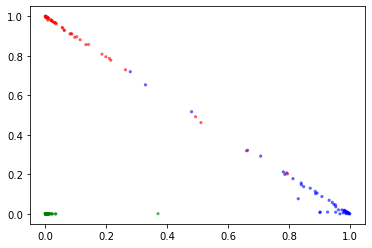

Average loss over epoch 44: 0.4037


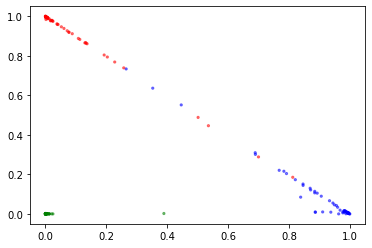

Average loss over epoch 45: 0.4049


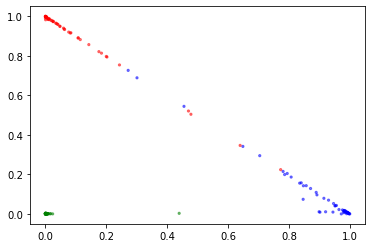

Average loss over epoch 46: 0.4026


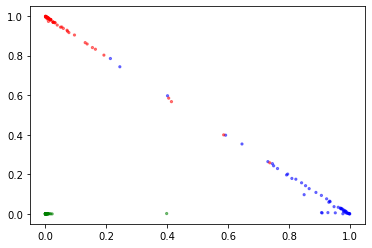

Average loss over epoch 47: 0.4040


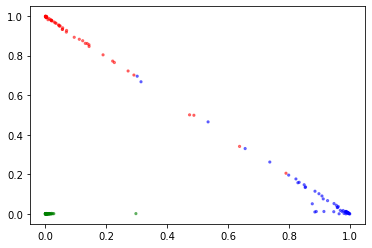

Average loss over epoch 48: 0.4021


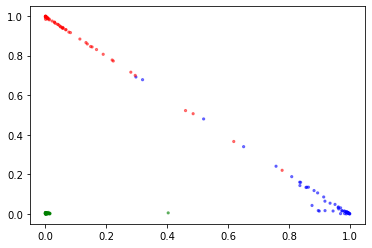

Average loss over epoch 49: 0.4050


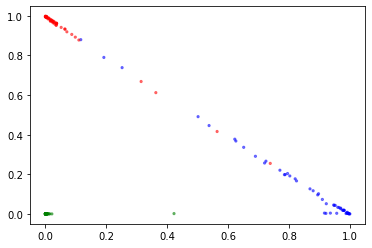

Average loss over epoch 50: 0.4067


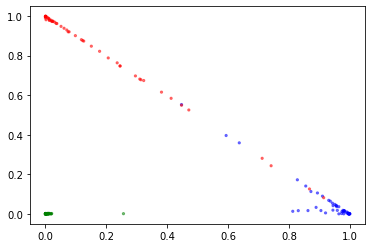

Average loss over epoch 51: 0.4071


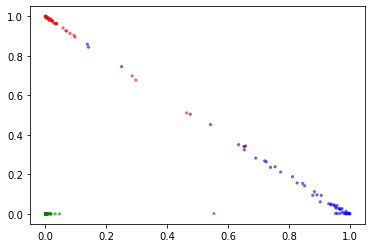

Average loss over epoch 52: 0.4054


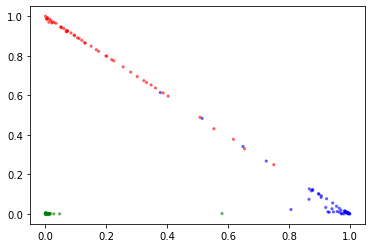

Average loss over epoch 53: 0.4048


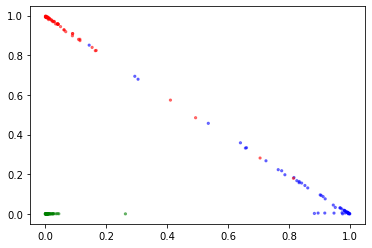

Average loss over epoch 54: 0.4069


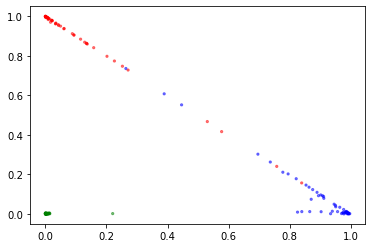

Average loss over epoch 55: 0.4064


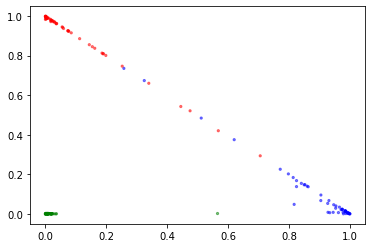

Average loss over epoch 56: 0.4044


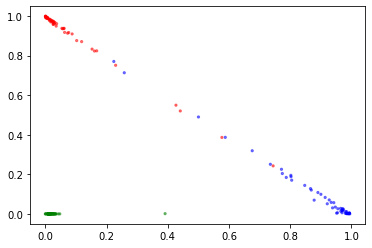

Average loss over epoch 57: 0.4046


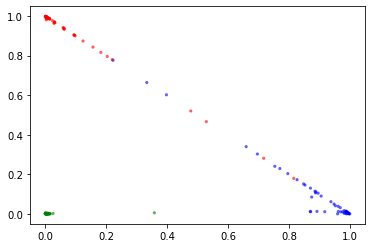

Average loss over epoch 58: 0.4047


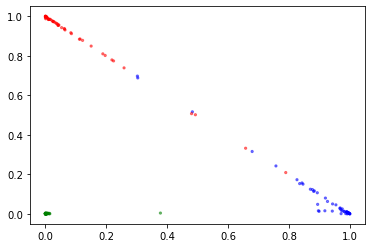

Average loss over epoch 59: 0.4014


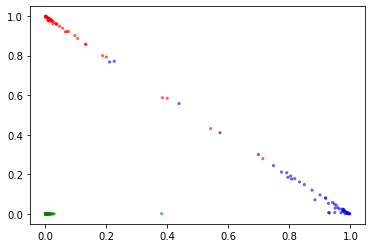

Average loss over epoch 60: 0.4004


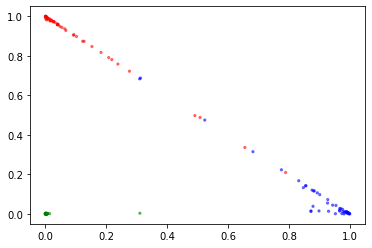

Average loss over epoch 61: 0.4010


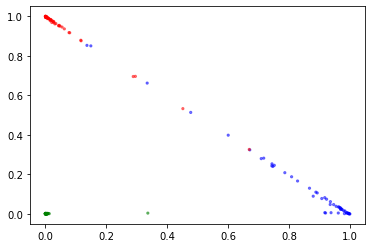

Average loss over epoch 62: 0.4003


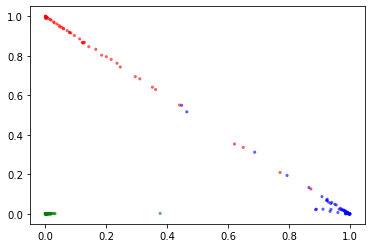

Average loss over epoch 63: 0.4035


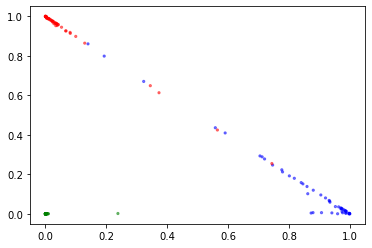

Average loss over epoch 64: 0.4027


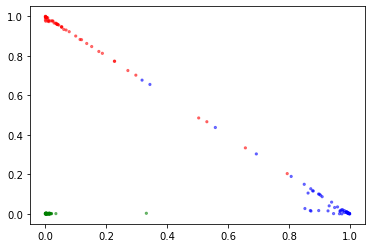

Average loss over epoch 65: 0.4016


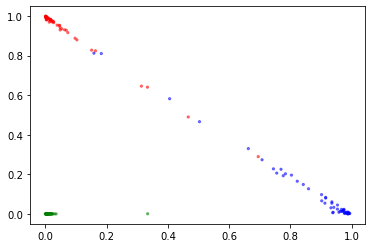

Average loss over epoch 66: 0.4061


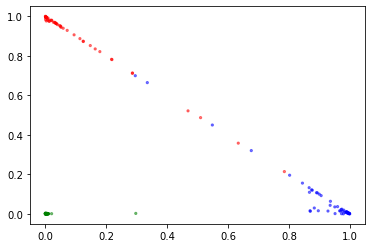

Average loss over epoch 67: 0.4005


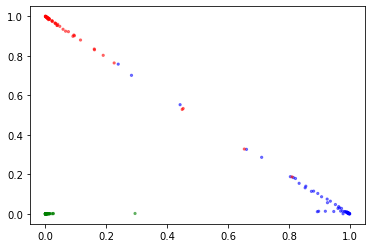

Average loss over epoch 68: 0.4009


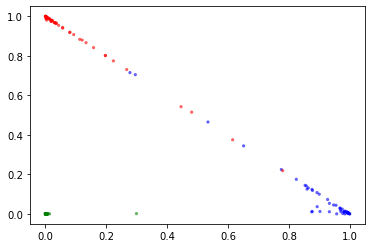

Average loss over epoch 69: 0.3996


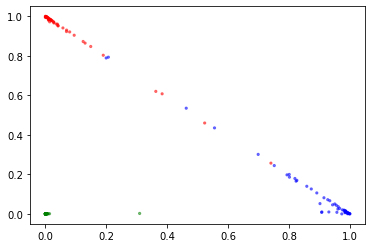

Average loss over epoch 70: 0.4014


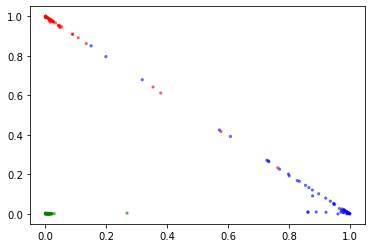

Average loss over epoch 71: 0.4056


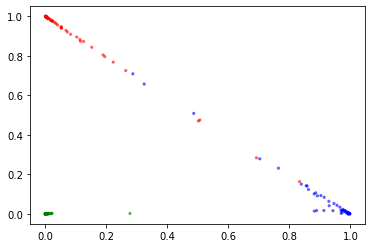

Average loss over epoch 72: 0.4033


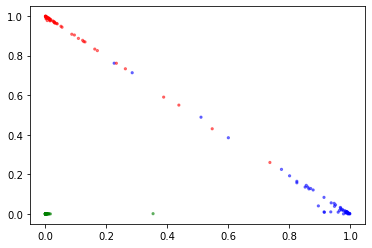

Average loss over epoch 73: 0.3989


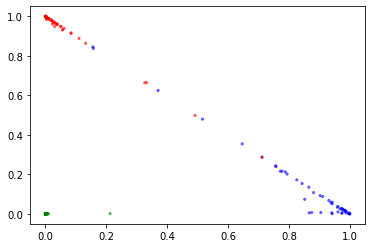

Average loss over epoch 74: 0.3993


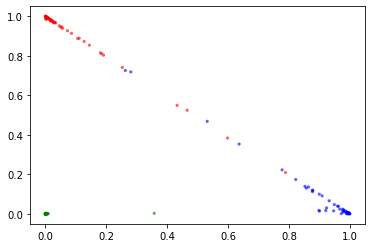

Average loss over epoch 75: 0.3995


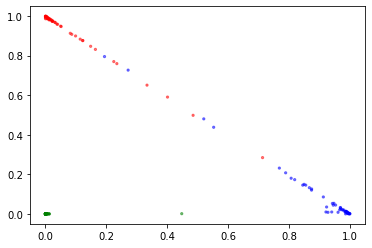

Average loss over epoch 76: 0.3997


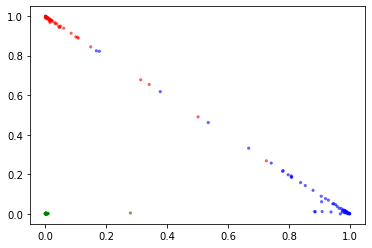

Average loss over epoch 77: 0.3990


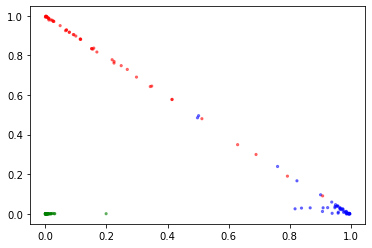

Average loss over epoch 78: 0.4063


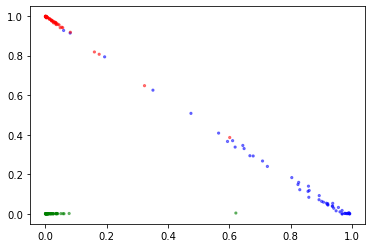

Average loss over epoch 79: 0.4048


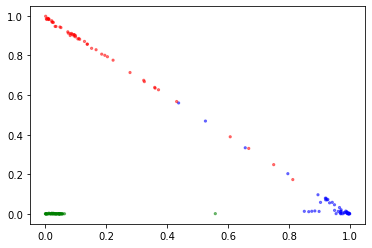

Average loss over epoch 80: 0.4096
Accuracy: 96.0%


In [41]:
%pylab inline
#y = y_hot.float()
#y_hot = y_hot.float()

batch_size = 30
batches = 300 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y)), batch_size=batch_size, shuffle=True, drop_last=True
)
epochs = 80

loss_list=[]
for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

#        print(xs)
        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()
#        print(xs, model(xs),ys,loss_evaluated)
        loss_list.append(loss_evaluated.detach().numpy())

        opt.step()

        running_loss += loss_evaluated
    y_pred = model(X)
    test_plot_model(y_pred)

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Populating the interactive namespace from numpy and matplotlib


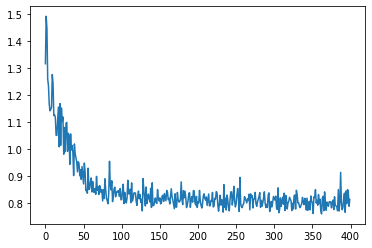

In [42]:
%pylab inline
plot(loss_list)

In [43]:
pbs_arr=[]
for xii, (x_lab, y_lab) in enumerate(zip(X,y)):
    pbs=y_pred[xii].detach().numpy()
    pbs_arr.append(pbs[:3])
    idx_max=np.argmax(pbs[:3])
#    y_lab_pred="0" if idx_max==1 else "1"
    print(int(y_lab), " ", idx_max, " ", pbs)
pbs_arr=np.array(pbs_arr)

0   0   [9.4457930e-01 5.4648936e-02 4.1994298e-04 3.5076123e-04]
0   0   [9.9119782e-01 8.4595717e-03 1.4985667e-04 1.9217299e-04]
0   0   [9.6810210e-01 3.0949073e-02 2.1715669e-04 7.3173095e-04]
0   0   [9.9576277e-01 3.5295105e-03 2.5032699e-04 4.5723113e-04]
0   0   [9.5431310e-01 4.4873130e-02 4.9567281e-04 3.1774607e-04]
0   0   [9.7213900e-01 2.5137438e-02 2.6529159e-03 7.0081580e-05]
0   0   [9.6178412e-01 3.7519578e-02 7.7656696e-05 6.1830395e-04]
0   0   [9.5366603e-01 4.5729157e-02 2.3083515e-04 3.7376638e-04]
0   0   [9.5114082e-01 4.8430856e-02 3.1841220e-04 1.0979329e-04]
0   0   [9.9675673e-01 2.6954508e-03 1.5750063e-04 3.9007168e-04]
0   0   [9.5165461e-01 4.6592016e-02 1.5963105e-03 1.5618742e-04]
0   0   [9.6588486e-01 3.3584051e-02 1.6882729e-04 3.6191271e-04]
0   0   [9.9411470e-01 5.2998620e-03 2.9364345e-04 2.9140030e-04]
0   0   [9.9825066e-01 7.0453592e-05 1.0053683e-03 6.7290274e-04]
0   0   [9.7544229e-01 2.1505576e-02 2.7524722e-03 2.9894133e-04]
0   0   [9

Populating the interactive namespace from numpy and matplotlib


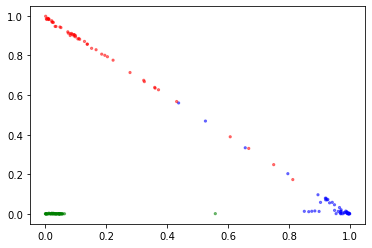

In [44]:
%pylab inline
colors=['g','b','r']
color_points=[colors[yv] for yv in y]
scatter(pbs_arr[:,1],pbs_arr[:,2],c=color_points,alpha=0.5,s=5)

In [45]:
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 96.0%
